<div align='center'>

# Practica 4

<img src='https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExaWJ5ZTduc2J4d2FkczRtNnc2cHBwMHVoZWlzOWw1MDF6bnIzeWNpZyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/HfJf5Vf9kvcTm/giphy.gif'>

</div>

---

## Ejercicio 1

El siguiente job en MapReduce permite contabilizar cuantas palabras comienzan con cada una de las letras del abecedario.

```python
def map(key, values, context):
    words = values.split()
    for w in words:
        context.write(w[0], 1)

def reduce(key, values, context):
    c=0
    for v in values:
        c=c+1
    context.write(key, c)
```

#### a. Solucione el problema del “case sensitive” usando comparadores.

In [ ]:
import sys
sys.path.append("..") 
from MRE import Job

inputDir = "./practica_4/ejercicio_1/"
outputDir = "./practica_4/ejercicio_1/output"

def map(key, values, context):
    words = values.split()
    for w in words:
        context.write(w[0], 1)

def reduce(key, values, context):
    c = 0
    for v in values:
        c += 1
    # normalizamos a minúscula para el output
    context.write(key.lower(), c)

# --- Comparadores case-insensitive ---
def shuffle_case_insensitive(k1, k2):
    if k1.lower() == k2.lower():
        return 0
    elif k1.lower() < k2.lower():
        return -1
    else:
        return 1

def sort_case_insensitive(k1, k2):
    if k1.lower() == k2.lower():
        return 0
    elif k1.lower() < k2.lower():
        return -1
    else:
        return 1

# Configuración del job
job = Job(inputDir, outputDir, map, reduce)
job.setShuffleCmp(shuffle_case_insensitive)
job.setSortCmp(sort_case_insensitive)

success = job.waitForCompletion()
print(success)


#### b. ¿Cuántos reducers se ejecutan en este problema?  Sabiendo que se cuenta con el doble de nodos para la tarea de reduce

En este caso, la clave es la primera letra de cada palabra. Eso significa que habrá como máximo 26 claves diferentes (a–z). Por lo tanto, se ejecutará un reducer por cada letra presente en los datos. Si el dataset solo tiene palabras con 10 letras distintas, entonces habrá 10 reducers efectivos; si están las 26 letras, serán 26.

**¿Cómo podría usar los comparadores para aprovechar todos los nodos?**

Si contamos con el doble de nodos de reduce (más de los 26 posibles), algunos quedarían ociosos porque no hay más de 26 claves naturales. Para aprovecharlos, se puede:

* **Particionar las claves en sub-claves**, por ejemplo transformar la letra `A` en `(A,0)` y `(A,1)` según un criterio (hash, posición, etc.).
* Usar un **comparador de Shuffle** que considere equivalentes todas las sub-claves con la misma letra (`A0` y `A1` se agrupan luego como “A”), pero que en la fase de distribución permita repartir la carga entre distintos reducers.
  De esta forma, se paraleliza más el trabajo y luego se consolidan los resultados parciales.


---

## Ejercicio 2

#### **¿Qué operaciones de resumen realizadas por los reducers se ven beneficiados por la definición de funciones de comparación personalizadas?**

* **GROUP BY + agregación** (ej. sumas, conteos, promedios).

  * Un comparador de *shuffle* puede agrupar claves equivalentes bajo un mismo criterio (ej. mayúsculas = minúsculas, agrupar por la primer letra, agrupar por ID de cliente sin importar el prefijo).
* **DISTINCT**.

  * Un comparador puede unificar tuplas que son “distintas en el valor crudo” pero equivalentes según un criterio (ej. “Juan Pérez” y “JUAN PÉREZ”).
* **JOINs**.

  * Comparadores son fundamentales: en *shuffle* garantizan que todos los registros con el mismo identificador vayan al mismo reducer; en *sort* permiten que lleguen ordenados de cierta manera (ej. primero el cliente y después sus cuentas).
* **Ordenamientos previos a agregados complejos**.

  * Por ejemplo, calcular mínimos/máximos o consolidar en orden temporal.

En general: **todo resumen que requiera agrupar o consolidar datos equivalentes bajo reglas distintas de la igualdad exacta de claves.**

#### ¿Qué consideraciones habría que tener en cuenta relacionado con la tarea de los mappers?

* **Definición de la clave intermedia**:
  El mapper debe emitir las claves de forma consistente con el criterio que luego aplicarán los comparadores.
  Ejemplo: si el comparador de shuffle agrupa por la primer letra, el mapper debe emitir como clave la palabra o un prefijo de ella.

* **Etiquetado para joins**:
  En joins 1:1 o 1\:n es clave que el mapper agregue etiquetas (“C” para cliente, “CA” para caja) porque el comparador por sí solo no distingue el origen.

* **Minimizar datos**:
  Emitir solo lo necesario (filtrado y proyección) para no sobrecargar shuffle/sort.

* **Consistencia en el formato**:
  Si se usan claves compuestas (tuplas), el mapper debe respetar esa estructura (ej. `(“C”, id_cliente)` vs `(“CA”, id_cliente)`).

---

## Ejercicio 3

**¿La operación de inner join mejora su performance con la función combiner?**

No, la operación de **inner join** no mejora su performance con la función **combiner**.

**Razón**

* El **combiner** solo sirve cuando la función de reducción es **asociativa y conmutativa** (ej. `SUM`, `COUNT`, `MAX`, etc.), porque permite resumir valores localmente en cada nodo antes de mandarlos al shuffle.
* En un **inner join**, el reducer necesita recibir **todos los registros de ambas tablas con la misma clave** para poder emparejarlos.
* Si un combiner “juntara” o filtrara datos en el mapper, correría el riesgo de descartar registros que en otro nodo tenían su par → se rompería el join.

**Conclusión**

El join requiere la totalidad de los datos asociados a una clave, por lo que **no es seguro ni útil aplicar un combiner**.
El combiner se aprovecha en operaciones de **resumen numérico**, pero no en **joins**.

---

## Ejercicio 4

Muchos cálculos aritméticos necesitan ordenar una serie de números para obtener su resultado, como por ejemplo la mediana.
La mediana es el "número en el medio" de una lista ordenada de números.

```
3, 5, 7, 12, 13, 14, 21, 23, 23, 23, 23, 29, 39, 40, 56
```

Implemente una solución MapReduce que permita calcular la mediana de una serie de valores. Use como prueba el dataset website para calcular la mediana del tiempo de permanencia.



#### Idea general

La mediana requiere:

1. **Contar la cantidad total de elementos (N)**.
2. **Ordenar los valores numéricos**.
3. Conocer el índice central:

   * Si N es impar → elemento en posición $(N+1)/2$.
   * Si N es par → promedio de los elementos en posiciones $N/2$ y $N/2+1$.

En MapReduce:

* Un primer job calcula N.
* Un segundo job ordena los valores y calcula la mediana usando N como parámetro.

In [ ]:
import sys
sys.path.append("..") 
from MRE import Job

inputDir = "./practica_2_hadoop_mapReduce/website/input/"
outputDirCount = "./practica_2_hadoop_mapReduce/website/ej4_count/"
outputDirMedian = "./practica_2_hadoop_mapReduce/website/ej4_median/"

# -------------------------------
# Job 1: contar cantidad de valores
# -------------------------------

def fmap_count(key, value, context):
    # cada línea cuenta como 1
    context.write(1, 1)

def fred_count(key, values, context):
    c = 0
    for v in values:
        c += 1
    context.write("N", c)

# -------------------------------
# Job 2: calcular mediana
# -------------------------------

def fmap(key, value, context):
    columnas = value.split("\t")
    tiempo = columnas[1]   # columna con "tiempo de permanencia"
    context.write(tiempo, tiempo)

def fshuffle(aKey, anotherKey):
    # todos los valores van al mismo reducer
    return 0

def fsort(aKey, anotherKey):
    num1 = float(aKey)
    num2 = float(anotherKey)
    if num1 == num2:
        return 0
    elif num1 < num2:
        return -1
    else:
        return 1

def fred(key, values, context):
    N = context["N"]   # cantidad total, pasada como parámetro
    mediana = None
    i = 1  # posición 1-based

    if N % 2 == 0:
        valor_izq = None
        valor_der = None
        for v in values:
            if i == N//2:
                valor_izq = float(v)
            elif i == N//2 + 1:
                valor_der = float(v)
                break
            i += 1
        mediana = (valor_izq + valor_der) / 2
    else:
        for v in values:
            if i == (N+1)//2:
                mediana = float(v)
                break
            i += 1

    context.write("mediana", mediana)

# -------------------------------
# Ejecutar ambos jobs
# -------------------------------

# 1) contar N
jobCounter = Job(inputDir, outputDirCount, fmap_count, fred_count)
jobCounter.waitForCompletion()

# leer N desde output del primer job
N = None
with open(outputDirCount + "/output.txt", "r") as arch:
    linea = arch.readline()
    N = int(linea.split("\t")[1])

# 2) calcular mediana
jobMedian = Job(inputDir, outputDirMedian, fmap, fred)
jobMedian.setShuffleCmp(fshuffle)
jobMedian.setSortCmp(fsort)
jobMedian.setParams({"N": N})
jobMedian.waitForCompletion()


---

## Ejercicio 5

Implemente una solución MapReduce para el método de Jacobi utilizando el dataset jacobi2 y los valores iniciales están en un dataset con el formato:

| incognita_i | valor |
|-------------|-------|
| var1        | 1     |
| var2        | 2     |
| var3        | 3     |

> Nota: En esta solución los valores de las incógnitas NO pueden ser pasados por parámetros a los mappers y reducers. Deben ser recibidos como una entrada del job.

```python
# Mapper 1: matriz A y vector b
# Formato de entrada: (i, [a_i1, a_i2, ..., a_in, b_i])
def fmap_matrix(key, value, context):
    fila = value.split("\t")
    incog = fila[0]          # var1, var2, ...
    coef = [float(x) for x in fila[1:-1]]
    b = float(fila[-1])
    context.write(incog, ("fila", coef, b))

# Mapper 2: valores actuales de las incógnitas
# Formato de entrada: (incognita, valor)
def fmap_values(key, value, context):
    incog, val = value.split("\t")
    context.write(incog, ("valor", float(val)))

# Reduce: calcula nueva iteración de Jacobi
def fred(key, values, context):
    fila = None
    valor_actual = None

    for v in values:
        if v[0] == "fila":
            fila = v
        elif v[0] == "valor":
            valor_actual = v[1]

    if fila is not None and valor_actual is not None:
        _, coef, b = fila
        # Jacobi: x_i^(k+1) = (b_i - sum_{j!=i} a_ij * x_j) / a_ii
        a_ii = coef[int(key[-1]) - 1]   # diagonal
        suma = 0
        for j, a_ij in enumerate(coef):
            if j != (int(key[-1]) - 1):
                # acá deberíamos acceder a los valores x_j
                # (recibidos en shuffle)
                pass
        nuevo = (b - suma) / a_ii
        context.write(key, nuevo)
```

A probarlo a narnia xd


## Ejercicio 6

#### Implemente una solución MapReduce que permita crear el dataset con valores iniciales arbitrarios para Jacobi. Suponiendo que hay 1000000 de variables


> Nota: Piense como entrada del job un único archivo con un único valor: el número de variables que hay que crear.

**📌 Planteo**

* Entrada: un archivo con un único número `N` (ej. `1000000`) → cantidad de variables a generar.
* Salida: dataset con `N` registros del tipo:

```
var1    v1
var2    v2
...
varN    vN
```

donde `vi` es un valor inicial arbitrario (ej. 0, 1, o un random).

**📌 Estrategia MapReduce**

1. **Mapper**: lee el número `N` y genera todas las variables con su valor inicial.

   * Para aprovechar el paralelismo, no debe hacerlo un único mapper (porque sería secuencial).
   * Una técnica es **dividir el rango 1..N en fragmentos** y que cada mapper procese uno.

2. **Reducer**: no es necesario resumir nada, solo escribir los pares `(var_i, valor)`.

**📌 Implementación simple (secuencial en un mapper)**

```python
def fmap_generate(key, value, context):
    N = int(value.strip())   # número de variables
    for i in range(1, N+1):
        context.write(f"var{i}", 0.0)   # valor inicial arbitrario = 0.0

def fred_generate(key, values, context):
    for v in values:
        context.write(key, v)
```

Esto funciona pero no escala si `N` es muy grande → todo queda en un único mapper.

### ¿Cómo optimizaría la creación de todos los valores aprovechando la capacidad de paralelismo del paradigma?

Para aprovechar la capacidad de MapReduce:

* **División del trabajo**:

  * El archivo de entrada puede contener un único valor `N`.
  * El mapper puede emitir **rango de índices** en vez de cada variable.
  * Reducers distintos procesan esos rangos y generan las variables.

* **Ejemplo**: con `N = 1,000,000` y 10 mappers:

  * Cada mapper procesa 100,000 variables.
  * `mapper1 → var1..var100000`
  * `mapper2 → var100001..var200000`
  * etc.

* **Pseudocódigo optimizado**:

```python
def fmap_generate(key, value, context):
    N = int(value.strip())
    chunk = N // 10   # si hay 10 mappers
    for m in range(10):
        start = m*chunk + 1
        end = (m+1)*chunk if m < 9 else N
        context.write(m, (start, end))

def fred_generate(key, values, context):
    for (start, end) in values:
        for i in range(start, end+1):
            context.write(f"var{i}", 0.0)
```

De esta forma, cada reducer genera un bloque de variables → se distribuye el trabajo.

## Ejercicio 7

Dado el dataset Banco (visto en teoría) el cual está compuesto por tres datasets:
- Cliente: <ID_Cliente, nombre, apellido, DNI, fecha de nacimiento, nacionalidad>
- CajaDeAhorro: <ID_Caja, ID_Cliente, saldo>
- Prestamos: <ID_Caja, cuotas, monto>

Implemente una solución MapReduce para resolver las siguientes consultas SQL describiendo el DAG correspondiente

---

### Parte a

```sql
SELECT nacionalidad, Count(*) AS cuantos
FROM Cliente AS C INNER JOIN CajaDeAhorro AS CA
    ON C.ID_Cliente = CA.ID_Cliente
        INNER JOIN Prestamos AS P
            ON CA.ID_Caja = P.ID_Caja
GROUP BY nacionalidad
ORDER BY cuantos DESC
LIMIT 1
```

**Pasos en MapReduce**

1. **JOIN Cliente – CajaDeAhorro (1\:N)** por `ID_Cliente`.

   * Mapper emite `(ID_Cliente, (“C”, datosCliente))` y `(ID_Cliente, (“CA”, datosCaja))`.
   * Reducer arma `(ID_Caja, nacionalidad)`.

2. **JOIN con Préstamos** por `ID_Caja`.

   * Mapper emite `(ID_Caja, (“CA”, nacionalidad))` y `(ID_Caja, (“P”, datosPrestamo))`.
   * Reducer obtiene `(nacionalidad, 1)` por cada préstamo asociado.

3. **GROUP BY nacionalidad**:

   * Reducer acumula conteo.

4. **ORDER BY y LIMIT**:

   * Puede resolverse en un paso final fuera de MapReduce o con un reducer único que calcule el máximo.

**DAG**

* Job 1: join Cliente–CajaDeAhorro.
* Job 2: join con Préstamos.
* Job 3: group by nacionalidad → count.
* Job 4 (opcional): max(count).

### Parte b

```sql
SELECT (Year(fecha_nacimiento) % 100) AS decada,
    Avg(saldo)
FROM Cliente AS C INNER JOIN CajaDeAhorro AS CA
    ON C.ID_Cliente = CA.ID_Cliente
WHERE nacionalidad = “ITA”
GROUP BY decada
```

**Pasos en MapReduce**

1. **JOIN Cliente – CajaDeAhorro (1\:N)** por `ID_Cliente`.

   * Mapper emite `(ID_Cliente, (“C”, datosCliente))`, `(ID_Cliente, (“CA”, saldo))`.
   * Reducer produce tuplas `(decada, saldo)` solo para nacionalidad = ITA.

2. **GROUP BY decada**:

   * Reducer acumula suma y cuenta de saldos.
   * Calcula promedio `sum / count`.

**DAG**

* Job 1: join Cliente–CajaDeAhorro con filtro nacionalidad.
* Job 2: group by decada → avg(saldo).

## Parte c

```sql
SELECT nombre, apellido, DNI
FROM Cliente AS C INNER JOIN CajaDeAhorro AS CA
    ON C.ID_Cliente = CA.ID_Cliente
WHERE C.ID_Cliente IN (
    SELECT ID_Cliente
    FROM CajaDeAhorro AS CA INNER JOIN
        Prestamos AS P ON CA.ID_Caja = P.ID_Caja
     GROUP BY ID_Cliente
     HAVING Count(*) > 2 
)
AND Year(fecha_nacimiento) < 2000
GROUP BY C.ID_Cliente
HAVING Max(saldo) > 500000
```

**Pasos en MapReduce**

1. **Subconsulta**:

   * JOIN CajaDeAhorro–Préstamos por `ID_Caja`.
   * Reducer agrupa por `ID_Cliente`, cuenta préstamos.
   * Filtra clientes con más de 2 préstamos.

2. **JOIN Cliente–CajaDeAhorro** por `ID_Cliente`.

   * Reducer combina datos del cliente con saldos.
   * Filtra `Year(fecha_nacimiento) < 2000`.

3. **Filtro HAVING Max(saldo) > 500000**:

   * Reducer por `ID_Cliente` obtiene saldo máximo.
   * Solo emite clientes que cumplen la condición.

4. **Proyección final**: `(nombre, apellido, DNI)`.

**DAG**

* Job 1: join CajaDeAhorro–Préstamos → group by cliente → count > 2.
* Job 2: join Cliente–CajaDeAhorro.
* Job 3: aplicar filtros (fecha\_nacimiento < 2000 y max(saldo) > 500000).
* Job 4: proyección de nombre, apellido, DNI.

In [2]:
import sys
sys.path.append("..")
from MRE import Job

clientesDir   = "./practica_4/Banco/clientes/"
cajasDir      = "./practica_4/Banco/cajas/"
prestamosDir  = "./practica_4/Banco/prestamos/"
outJoinCA_P   = "./practica_4/Banco/out_join_ca_p/"
outJoinC_CA_P = "./practica_4/Banco/out_join_c_ca_p/"
outGroup      = "./practica_4/Banco/out_group/"
outFinal      = "./practica_4/Banco/out_final/"

# ==================== JOB 0: JOIN CAJA–PRÉSTAMO POR ID_CAJA ====================
# CA input line:  key=id_caja, value="id_cliente \t saldo"
# P  input line:  key=id_caja, value="cuotas \t monto"

def fmap_CA(key, value, context):
    cols = value.strip().split()  # -> [id_cliente, saldo]
    if len(cols) == 2:
        id_cliente, saldo = cols
        context.write(key, ("CA", id_cliente, saldo))  # key=id_caja

def fmap_P(key, value, context):
    cols = value.strip().split()  # -> [cuotas, monto]
    if len(cols) == 2:
        cuotas, monto = cols
        context.write(key, ("P", cuotas, monto))        # key=id_caja

def fred_CA_P(key, values, context):
    # key es id_caja
    datos_caja, datos_prestamo = None, None
    for v in values:
        if v[0] == "CA":
            datos_caja = v    # ("CA", id_cliente, saldo)
        elif v[0] == "P":
            datos_prestamo = v  # ("P", cuotas, monto)

    # INNER JOIN: sólo si hay préstamo para esa caja
    if datos_caja and datos_prestamo:
        _, id_cliente, saldo = datos_caja
        _, cuotas, monto     = datos_prestamo
        # Emite por id_cliente (vamos a joinear con Clientes)
        # Escribimos 5 cols en el value para que el próximo map pueda leerlas:
        # id_cliente, id_caja, saldo, cuotas, monto
        context.write(id_cliente, [id_cliente, key, saldo, cuotas, monto])

# ==================== JOB 1: JOIN CLIENTE – (CA+P) POR ID_CLIENTE ====================
# Clientes input: key=id_cliente, value="nombre \t apellido \t dni \t fn \t nac"
# T intermedio:   key=id_cliente, value="id_cliente \t id_caja \t saldo \t cuotas \t monto"
# Usamos clave compuesta (id_cliente, "C"/"CA") + comparadores para agrupar por id_cliente
# y ordenar el cliente primero (como en tu ejemplo).

def fmap_C(key, value, context):
    cols = value.strip().split()  # -> [nombre, apellido, dni, fn, nac]
    if len(cols) == 5:
        context.write((key, "C"), cols)

def fmap_T(key, value, context):
    cols = value.strip().split()  # -> [id_cliente, id_caja, saldo, cuotas, monto]
    if len(cols) == 5:
        id_cliente = cols[0]
        # etiqueto como "CA" para que el sort ponga primero C y después CA
        context.write((id_cliente, "CA"), cols)

def fshuffle_1(aKey, anotherKey):
    # agrupa por id_cliente (ignora el tag)
    id1, id2 = aKey[0], anotherKey[0]
    if id1 == id2: return 0
    return -1 if id1 < id2 else 1

def fsort_1(aKey, anotherKey):
    # ordena dentro del mismo cliente: primero "C", luego "CA"
    t1, t2 = aKey[1], anotherKey[1]
    if t1 == t2: return 0
    return -1 if t1 == "C" else 1

def fred_C_CA_P(key, values, context):
    # key = (id_cliente, tag)
    datos_cliente = None
    primero = True

    # precondición: sort ya dejó primero el cliente "C"
    for v in values:
        if primero:
            datos_cliente = v           # [nombre, apellido, dni, fn, nac]
            primero = False
        else:
            # v es ["id_cliente","id_caja","saldo","cuotas","monto"]
            if datos_cliente:
                nac = datos_cliente[4]
                context.write(nac, 1)   # una fila (caja-préstamo) cuenta para su nacionalidad

# ==================== JOB 2: GROUP BY NACIONALIDAD → COUNT ====================

def fmap_group(key, value, context):
    # key = nacionalidad, value = 1
    context.write(key, 1)

def fred_group(key, values, context):
    c = 0
    for v in values:
        c += v
    context.write(key, c)

# ==================== JOB 3: ORDENAR DESC Y QUEDARSE CON EL TOP 1 ====================

def fmap_final(key, value, context):
    # invertimos (nac, count) -> (count, (nac, count)) para ordenar por count
    context.write(value, (key, value))  # key=count

def fshuffle_final(aKey, anotherKey):
    # todo al mismo reducer para poder elegir el top 1 global
    return 0

def fsort_final(aKey, anotherKey):
    # ordenar count de mayor a menor
    c1, c2 = int(aKey), int(anotherKey)
    if c1 == c2: return 0
    return -1 if c1 > c2 else 1

def fred_final(key, values, context):
    # precondición: ya llegan ordenados desc por count
    for v in values:
        context.write(v[0], v[1])  # nacionalidad, cuantos
        break  # sólo el primero (LIMIT 1)

# ==================== PIPELINE ====================

# 1) join Caja–Prestamos
job0 = Job(cajasDir, outJoinCA_P, fmap_CA, fred_CA_P)
job0.addInputPath(prestamosDir, fmap_P)
job0.waitForCompletion()

# 2) join Cliente–(Caja+Prestamo)
job1 = Job(clientesDir, outJoinC_CA_P, fmap_C, fred_C_CA_P)
job1.addInputPath(outJoinCA_P, fmap_T)
job1.setShuffleCmp(fshuffle_1)
job1.setSortCmp(fsort_1)
job1.waitForCompletion()

# 3) group by nacionalidad
job2 = Job(outJoinC_CA_P, outGroup, fmap_group, fred_group)
job2.waitForCompletion()

# 4) order by desc y top 1
job3 = Job(outGroup, outFinal, fmap_final, fred_final)
job3.setShuffleCmp(fshuffle_final)
job3.setSortCmp(fsort_final)
job3.waitForCompletion()


[MRE] INICIANDO ETAPA DE MAPEO...
[Map] 399580 -> ('P', '54', '1432.83477152364')
[Map] 223438 -> ('P', '114', '8637.88558609685')
[Map] 635308 -> ('P', '63', '9331.09276948082')
[Map] 975864 -> ('P', '117', '7540.01434023493')
[Map] 208937 -> ('P', '32', '6308.05972800965')
[Map] 271430 -> ('P', '44', '2077.52049373347')
[Map] 339466 -> ('P', '14', '110.984104830299')
[Map] 698825 -> ('P', '32', '3830.5293321286')
[Map] 31840 -> ('P', '87', '9579.36095920362')
[Map] 669778 -> ('P', '79', '212.334442796341')
... [más resultados de map omitidos]
[MRE] INICIANDO ETAPA DE REDUCCIÓN...
[Reduce] Clave recibida: 1 -> [('CA', '33543', '93034.0330084013')]
[Reduce] Clave recibida: 100012 -> [('CA', '63105', '63567.8460651859')]
[Reduce] Clave recibida: 100013 -> [('CA', '96392', '41048.2177236342')]
[Reduce] Clave recibida: 100021 -> [('CA', '86722', '5582.71478190213')]
[Reduce] Clave recibida: 100026 -> [('CA', '27125', '73027.2587263152')]
[Reduce] Clave recibida: 100033 -> [('CA', '96328',

True

---

## Ejercicio 8

El banco almacena en un cuarto archivo (llamado Movimientos) todas las transacciones realizadas y las almacena con este formato:

\<ID_Caja, monto, timestamp>

Donde para cada caja de ahorro almacena en un determinado timestamp \(en formato AAAA-MM-DD HH:mm:SS) el monto del movimiento (puede ser negativo o positivo según si se hizo una extracción o un depósito).

Implemente una solución en MapReduce que permita calcular para cada cliente del banco su media móvil (moving average) en un mes y año determinado. Tanto el año, como el mes y el ancho de la ventana deben ser parámetros de la consulta.

**Media móvil (moving average)**

Dada una serie numérica ordenada en el tiempo, la media móvil de ancho 5 se calcula como:

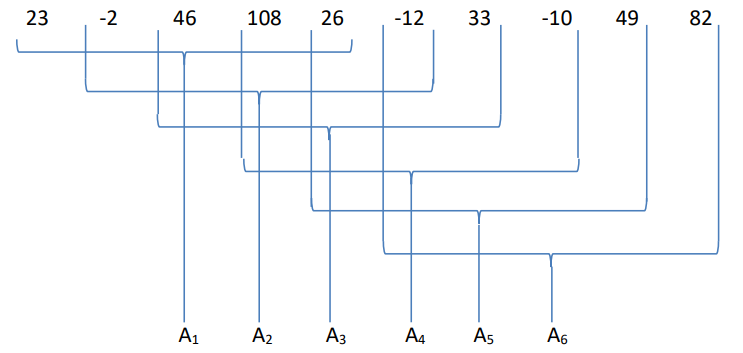

donde A1 .. A6 es el promedio aritmético de cada sub-serie de cinco valores. La media móvil es el promedio de todos los Ai.

* **Mapper**: lee `<id_caja, monto, timestamp>`, filtra por año/mes (`context["year"]`, `context["month"]`), emite `(id_caja, (fecha, monto))`.
* **Shuffle/Sort**: agrupa por caja y ordena por fecha.
* **Reducer**: con la lista de montos ordenada calcula la media móvil con ventana `W = context["window"]` y devuelve `<id_caja, media_movil>`.

```python
def fmap_mov(key, value, context):
    id_caja, monto, ts = value.strip().split()
    f = datetime.datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
    if f.year == context["year"] and f.month == context["month"]:
        context.write(id_caja, (f, float(monto)))

def fred_mov(id_caja, values, context):
    montos = [m for _, m in sorted(values, key=lambda x: x[0])]
    W = context["window"]
    proms = [sum(montos[i:i+W])/W for i in range(len(montos)-W+1)]
    if proms: context.write(id_caja, sum(proms)/len(proms))
```